In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter

from time import time

%matplotlib inline

import scipy.sparse

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('axes', labelsize='large') 

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [4]:
def normal_form(string):
    result = []
    for s in string.split(' '):
        result.append(morph.parse(s)[0].normal_form)
    
    return u' '.join(result)

print normal_form(u'постоянная Планка')

постоянный планка


In [5]:
def_black_list = {u'то есть', u'есть', u'здесь', u'найти', u'типа', u'любом', u'равной',
                  u'со значениями', u'мы можем', u'обозначается символом', u'другой',
                  u'образом', u'условие',
                  u'точка', u'степень', u'элемент', u'сумма',
                  u'значение', u'матрица', u'параметр', u'формула', u'константа',
                  u'коэффициент', u'нуль', u'уравнение', u'число', u'символ', u'себя',
                  u'переменный', u'вектор', u'координата', u'величина', u'порядок',
                  u'люба', u''}

id_replacement_list = {u'ℏ': 'h'}

def normalize_id(id):
    if id in id_replacement_list:
        return id_replacement_list[id]
    return id

def valid_def(definition):
    if len(definition) <= 3:
        return False

    return definition.lower() not in def_black_list

In [6]:
from collections import defaultdict

def id_counter(id_list):
    cnt = Counter()
    for el in id_list:
        id = el[u'element']
        cnt[normalize_id(id)] = el[u'count']
    return cnt

def rel_to_dict(rels):
    res = defaultdict(list)
    for r in rels:
        if not valid_def(r['definition']):
            continue
        normalized_def = normal_form(r['definition'])
        
        if not valid_def(normalized_def):
            continue
        
        id = r['identifier']
        res[normalize_id(id)].append((normalized_def, r['score']))
    return res

In [7]:
from collections import defaultdict

doc_categories = defaultdict(set)

for line in file('C:/tmp/mlp/ru_cats_extended.txt'):
    lst = line.strip().split('\t')
    title = lst[0].decode('utf-8')
    
    for cat in lst[1:]:
        cat = cat.decode('utf-8')
        doc_categories[title].add(cat)

In [8]:
root = 'C:/tmp/mlp/ru-out/'

docs = []
titles = []
ids = []
rels = []

empty = 0
small = 0
uncategorized = 0

cnt = 0
for f in os.listdir(root): 
    for line in file(root + f):
        cnt = cnt + 1
        doc = json.loads(line)

        title = doc['title']        
        if title not in doc_categories:
            uncategorized = uncategorized + 1
            continue

        if '(disambiguation)' in title:
            continue

        id_bag = id_counter(doc['identifiers'])
        if len(id_bag) <= 1:
            if len(id_bag) == 0:
                empty = empty + 1
            else:
                small = small + 1
            continue

        docs.append(doc)
        titles.append(title)
        ids.append(id_bag)

        id_rels = rel_to_dict(doc['relations'])
        rels.append(id_rels)


N_doc = len(ids)
print N_doc, cnt

5319 14905


In [9]:
title_idx = {title: idx for (idx, title) in enumerate(titles)}

for doc, cats in doc_categories.items():
    if doc in title_idx:
        continue

    for cat in cats: 
        category_docs[cat].remove(doc)
    
    del doc_categories[doc]

print len(doc_categories)

5319


In [10]:
doc_categories_list = [doc_categories[doc] for doc in titles]

## Some stats

In [19]:
cnt = Counter() 

for id_list in ids:
    cnt.update(id_list)

cnt_pd = pd.Series(cnt.values())
cnt_pd.sort(ascending=0, inplace=1)

In [21]:
cnt.most_common(10)

[(u'x', 13248),
 (u'n', 9224),
 (u'f', 4777),
 (u'b', 4132),
 (u'c', 3828),
 (u'd', 3534),
 (u'k', 3337),
 (u't', 3287),
 (u'p', 3124),
 (u'm', 3072)]

In [20]:
cnt_pd.describe()

count     2319.000000
mean        63.935748
std        454.266901
min          1.000000
25%          1.000000
50%          3.000000
75%          9.000000
max      13248.000000
dtype: float64

In [22]:
cnt_doc = pd.Series([sum(c.values()) for c in ids])
cnt_doc.sort(ascending=0, inplace=1)

In [25]:
cnt_doc[:5]

1014    1831
146     1266
92      1095
1120    1095
511     1066
dtype: int64

In [27]:
print titles[1014]

Уравнения Максвелла


In [23]:
cnt_doc.describe()

count    5319.000000
mean       27.874976
std        70.662725
min         2.000000
25%         4.000000
50%         9.000000
75%        22.000000
max      1831.000000
dtype: float64

In [29]:
cnt_doc_d = pd.Series([len(c.values()) for c in ids])
cnt_doc_d.sort(ascending=0, inplace=1)
cnt_doc_d[:5]

1014    112
146      83
246      82
4517     76
92       71
dtype: int64

In [30]:
cnt_doc_d.describe()

count    5319.000000
mean        7.376763
std         7.944677
min         2.000000
25%         3.000000
50%         5.000000
75%         8.000000
max       112.000000
dtype: float64

In [31]:
cnt_def = pd.Series([len(r) for r in rels])
cnt_def.sort(ascending=0, inplace=1)
cnt_def[:5]

1014    44
207     31
647     31
2297    30
2360    29
dtype: int64

In [32]:
cnt_def.describe()

count    5319.000000
mean        3.268660
std         3.249702
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        44.000000
dtype: float64

In [14]:
print titles[1447]

Корень многочлена


## Definitions

In [11]:
def_freq = Counter()

for def_dict in rels: 
    for id, def_list in def_dict.items():
        def_freq.update([(id, d) for d, s in def_list])

for (n, d), cnt in def_freq.most_common(20):
    print n, d, cnt

f функция 215
t время 130
X множество 113
m масса 103
c скорость свет 89
G группа 87
T температура 69
h постоянный планка 68
ρ плотность 57
M многообразие 53
K поль 53
x функция 53
X пространство 50
v скорость 50
M множество 48
X топологический пространство 46
G граф 44
n функция 40
V множество 38
R радиус 38


In [12]:
low_freq_def = {id for id, cnt in def_freq.items() if cnt == 1}
print len(low_freq_def)

for def_dict in rels: 
    for id, def_list in def_dict.items():
        clean_def_list = []
        for definition, score in def_list:
            if definition not in low_freq_def:
                clean_def_list.append((definition, score))
        
        if not clean_def_list:
            del def_dict[id]
        else:
            def_dict[id] = clean_def_list

24633


In [13]:
import cluster_evaluation
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

Now let's incorporate definitions into the vector space

In [14]:
for idx in xrange(N_doc):
    vals = rels[idx].items()
    id_list = ids[idx]

    for id, definitions in vals:
        for definition, score in definitions:
            unigrams = definition.lower().split()
            id_list[id] = id_list[id] + 1
            id_list.update(unigrams)

In [15]:
print ' '.join(ids[201].keys())

время S_ν среднеквадратический оператор значение γ α μ_0 β J_x J_y J_z μ момент J M L P всего U угловой компонент компонента g h вектор l алгебра p s y x z


## K-Means

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, randomized_svd

from sklearn.preprocessing import Normalizer
normalizer = Normalizer(copy=False)

In [17]:
def unwrap_counter(cnt):
    res = []
    for id, c in cnt.items():
        res.extend([id] * c)
    return res

vectorizer = TfidfVectorizer(analyzer=unwrap_counter, use_idf=True, sublinear_tf=True, min_df=2)
X = vectorizer.fit_transform(ids)

X

<5319x3948 sparse matrix of type '<type 'numpy.float64'>'
	with 79171 stored elements in Compressed Sparse Row format>

In [18]:
79171.0 / (X.shape[0] * X.shape[1])

0.0037701531833367525

In [19]:
km_grid_hyperparam_res = {}
km_grid_hyperparam_lr = []

In [36]:
for n in [150, 250, 350]:
    U, S, Vt = randomized_svd(X, n_components=n)
    V = Vt.T

    X_red_grid = X.dot(V)
    X_red_grid = normalizer.fit_transform(X_red_grid)

    ks = [k for k in xrange(500, 5001, 250)]
    
    for k in ks:
        km_grid = MiniBatchKMeans(n_clusters=k, init_size=k*3, n_init=10, init='random')
        km_grid.fit(X_red_grid)

        km_grid_hyperparam_res[(n, k)] = km_grid.labels_
        cluster_purity = evaluate.overall_purity(km_grid.labels_)
        no_pure_clusters = len(evaluate.high_purity_clusters(km_grid.labels_, threshold=0.8, min_size=3))
        km_grid_hyperparam_lr.append((n, k, cluster_purity, no_pure_clusters))

        print 'purity for n=%d, k=%d is %0.4f, number of >0.8 clusters: %d' % (n, k, cluster_purity, no_pure_clusters)

purity for n=150, k=500 is 0.3495, number of >0.8 clusters: 35
purity for n=150, k=750 is 0.4053, number of >0.8 clusters: 52
purity for n=150, k=1000 is 0.4362, number of >0.8 clusters: 49
purity for n=150, k=1250 is 0.4779, number of >0.8 clusters: 71
purity for n=150, k=1500 is 0.5198, number of >0.8 clusters: 85
purity for n=150, k=1750 is 0.5492, number of >0.8 clusters: 86
purity for n=150, k=2000 is 0.6007, number of >0.8 clusters: 102
purity for n=150, k=2250 is 0.6283, number of >0.8 clusters: 98
purity for n=150, k=2500 is 0.6627, number of >0.8 clusters: 79
purity for n=150, k=2750 is 0.6885, number of >0.8 clusters: 78
purity for n=150, k=3000 is 0.7210, number of >0.8 clusters: 85
purity for n=150, k=3250 is 0.7526, number of >0.8 clusters: 67
purity for n=150, k=3500 is 0.7772, number of >0.8 clusters: 65
purity for n=150, k=3750 is 0.8114, number of >0.8 clusters: 53
purity for n=150, k=4000 is 0.8389, number of >0.8 clusters: 43
purity for n=150, k=4250 is 0.8539, numbe

In [37]:
import pickle
pickle.dump(km_grid_hyperparam_res, file('C:/tmp/mlp/namespaces/rus-models-07-25-svd2.bin', 'w'))

In [20]:
import pickle
km_grid_hyperparam_res = pickle.load(file('C:/tmp/mlp/namespaces/rus-models-07-25-svd2.bin'))

In [38]:
df_nf = pd.DataFrame(km_grid_hyperparam_lr, columns=['n', 'k', 'purity', 'sizes'])
df_nf.head()

,n,k,purity,sizes
0,150,500,0.349502,35
1,150,750,0.405339,52
2,150,1000,0.436172,49
3,150,1250,0.477909,71
4,150,1500,0.519835,85


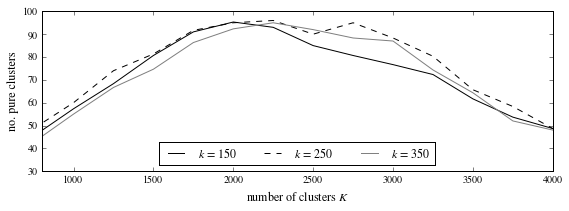

In [62]:
visual = {150: ('black', '-'), 250: ('black', '--'), 350: ('grey', '-') }

for n, g in df_nf.groupby('n'):
    color, line = visual[n]
    med = g.groupby('k').sizes.median()
    smoothed = pd.stats.moments.rolling_mean(med, window=3, center=True)
    smoothed.plot(figsize=(8, 3), label='$k$ = %d' % n, color=color, linestyle=line)

plt.grid(0)
plt.xlabel('number of clusters $K$')
plt.ylabel('no. pure clusters')
plt.legend(loc='lower center', ncol=4)
plt.xlim(800, 4000)
plt.ylim(30, 100)

plt.tight_layout()
plt.savefig('figures/k-vs-kmeans-rus.pdf', format='pdf')
plt.show()

In [66]:
df_nf.ix[df_nf.sizes.argmax()]

n          250.000000
k         3000.000000
purity       0.730024
sizes      105.000000
Name: 29, dtype: float64

In [21]:
from fuzzywuzzy import fuzz

In [22]:
clustering = km_grid_hyperparam_res[(250, 3000)]
evaluate.report_overall(clustering, purity_threshold=0.8, min_size=3, sort_by='size')

overall purity 0.7300
number of high purity clusters of size at least 5 is 105

- Общая алгебра (id=824) size=7, purity=0.8571
- Дифференциальная геометрия и топология (id=2215) size=7, purity=1.0000
- Дифференциальная геометрия и топология (id=41) size=6, purity=0.8333
- Функциональный анализ (id=833) size=6, purity=0.8333
- Животные (id=1775) size=6, purity=0.8333
- Картография (id=2288) size=6, purity=1.0000
- Математический анализ (id=7) size=5, purity=1.0000
- Математический анализ (id=90) size=5, purity=0.8000
- Теория вероятностей (id=216) size=5, purity=1.0000
- Механика (id=770) size=5, purity=0.8000
- Дифференциальные уравнения в частных производных (id=776) size=5, purity=0.8000
- Математический анализ (id=995) size=5, purity=0.8000
- Релятивистские и гравитационные явления (id=1056) size=5, purity=0.8000
- Линейная алгебра (id=1142) size=5, purity=1.0000
- Математический анализ (id=1415) size=5, purity=1.0000
- Физика твёрдого тела (id=1643) size=5, purity=0.8000
- Гидродин

In [23]:
evaluate.print_cluster(clustering, 1142, scorer=fuzz.UQRatio)

cluster 1142, size: 5
- Линейная алгебра (categories: Алгебра, Линейная алгебра) элемент V v_n древнекитайский вектор-строка книга α уравнение инвариантный v_1 v_2 подстановка L решение P комбинация l x то обратный тензорный число j порядок α_1 контравариантный базис W_i W_k девять β единичный подпространство α_n W математика векторный притом ковариантный k алгебраический W_1 сопрячь сложение x_n матрица возможность b_1 b_2 равенство в множество λ B b_m F роль размер x_2 x_1 поль b f группа вектор n r v характеристика пространство n_i n_k экземпляр отображение частное операция образ n_1 линейный U конструкция произведение m абелев u y
- Спектральная теорема (categories: Математические теоремы, Алгебра, Функциональный анализ, Линейная алгебра, Матрицы, ...) соответствие эрмитовый проектирование шура элемент матрица пространство гильбертов случай функция собственный Λ разложение диагональный равенство базис умножение скалярный оператор значение определение ортонормированный λ инвариантны

In [24]:
evaluate.find_identifier(clustering, purity_threshold=0.8, id=u'λ', min_size=3)

overall purity 0.7300
number of high purity clusters of size at least 5 is 105

category "Теория алгоритмов", cluster_id=1015, size=3:
top categories: [(u'\u0422\u0435\u043e\u0440\u0438\u044f \u0430\u043b\u0433\u043e\u0440\u0438\u0442\u043c\u043e\u0432', 3), (u'\u0422\u0435\u043e\u0440\u0438\u044f \u0430\u0432\u0442\u043e\u043c\u0430\u0442\u043e\u0432', 3), (u'\u0412\u0438\u0437\u0443\u0430\u043b\u0438\u0437\u0430\u0446\u0438\u044f \u0434\u0430\u043d\u043d\u044b\u0445', 1), (u'\u0414\u0438\u0430\u0433\u0440\u0430\u043c\u043c\u044b', 1)]
     λ: (функция выход: 1.90), (функция переход: 0.96)
category "Релятивистские и гравитационные явления", cluster_id=1056, size=5:
top categories: [(u'\u0420\u0435\u043b\u044f\u0442\u0438\u0432\u0438\u0441\u0442\u0441\u043a\u0438\u0435 \u0438 \u0433\u0440\u0430\u0432\u0438\u0442\u0430\u0446\u0438\u043e\u043d\u043d\u044b\u0435 \u044f\u0432\u043b\u0435\u043d\u0438\u044f', 4), (u'\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u044d\u0444\u0

## Hierarchies

In [25]:
grnti_file = file('C:/tmp/mlp/categories_ru_hierarchy.txt')
next(grnti_file) # header

tree_grnti = {}
top_parent = None
parent = None


for line in grnti_file:
    line = line.decode('utf8')
    code, name, level = line.strip().split(';')
    
    if level == '0':
        top_parent = name
        tree_grnti[top_parent] = {}
    elif level == '1':
        parent = name 
        tree_grnti[top_parent][parent] = [name]
    else:
        if name.lower().startswith(u'общие вопросы'):
            continue
        if name.lower().startswith(u'общие проблемы'):
            continue
        tree_grnti[top_parent][parent].append(name)

In [26]:
keep = [u'ЭКОНОМИКА. ЭКОНОМИЧЕСКИЕ НАУКИ', u'ИНФОРМАТИКА', u'МАТЕМАТИКА', u'КИБЕРНЕТИКА',
        u'ФИЗИКА', u'МЕХАНИКА', u'ХИМИЯ', u'БИОЛОГИЯ', u'ГЕОДЕЗИЯ. КАРТОГРАФИЯ', 
        u'ГЕОФИЗИКА', u'АСТРОНОМИЯ', u'ЭЛЕКТРОТЕХНИКА', u'ЭЛЕКТРОНИКА. РАДИОТЕХНИКА',
        u'ЯДЕРНАЯ ТЕХНИКА', u'ХИМИЧЕСКАЯ ТЕХНОЛОГИЯ.  ХИМИЧЕСКАЯ ПРОМЫШЛЕННОСТЬ', 
        u'БИОТЕХНОЛОГИЯ', u'СТАТИСТИКА', u'КОСМИЧЕСКИЕ ИССЛЕДОВАНИЯ', u'МЕТРОЛОГИЯ']

for k in tree_grnti.keys():
    if k not in keep:
        del tree_grnti[k]

In [27]:
print '\n'.join(sorted(tree_grnti.keys()))

АСТРОНОМИЯ
БИОЛОГИЯ
БИОТЕХНОЛОГИЯ
ГЕОДЕЗИЯ. КАРТОГРАФИЯ
ГЕОФИЗИКА
ИНФОРМАТИКА
КИБЕРНЕТИКА
КОСМИЧЕСКИЕ ИССЛЕДОВАНИЯ
МАТЕМАТИКА
МЕТРОЛОГИЯ
МЕХАНИКА
СТАТИСТИКА
ФИЗИКА
ХИМИЧЕСКАЯ ТЕХНОЛОГИЯ.  ХИМИЧЕСКАЯ ПРОМЫШЛЕННОСТЬ
ХИМИЯ
ЭКОНОМИКА. ЭКОНОМИЧЕСКИЕ НАУКИ
ЭЛЕКТРОНИКА. РАДИОТЕХНИКА
ЭЛЕКТРОТЕХНИКА
ЯДЕРНАЯ ТЕХНИКА


In [28]:
for k_top, top in tree_grnti.items():
    for k_2, v in top.items():
        if len(v) <= 1 :
            del top[k_2]

In [29]:
for top in sorted(tree_grnti.keys()):
    print top
    
    for sec, items in tree_grnti[top].items():
        print '   ', u', '.join(items)
    
    print 

АСТРОНОМИЯ
    Астрофизика, Элементарные частицы и поля в астрофизике, Приложение квантовой теории в астрофизике. Ядерные и атомно-молекулярные процессы, Теория поглощения и излучения. Перенос излучения, Методы статистической физики. Космическая электродинамика, Релятивистская астрофизика. Приложения общей теории относительности в астрономии, Происхождение элементов, Прочие проблемы теоретической астрофизики
    Звезды, Внутреннее строение и эволюция звезд, Статистические исследования, Атмосферы, Стационарные звезды, Физические переменные звезды, Звездообразные источники излучения, Двойные и кратные звезды
    Солнечная система, Строение и происхождение Солнечной системы, Планеты и их спутники, Луна. Лунные затмения, Кометы, Метеоры. Зодиакальный свет. Межпланетная среда, Метеориты
    Туманности. Межзвездная среда, Туманности, Межзвездная среда, Астрофизика космических лучей
    Звездные системы, Кинематика и динамика звездных систем, Звездные скопления и ассоциации, Строение и эволюц

In [30]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [31]:
def lemmatize_rus(t):
    return morph.parse(t)[0].normal_form

In [32]:
all_categories = []
all_categories_idx = {}

rus_sw = set(stopwords.words('russian'))
domain_sw = {u'метод', u'теория', u'общий', u'вопрос', u'исследование', u'организация'
             u'прочий', u'международный', u'научный'}

cnt = 0

for k_top, top in tree_grnti.items():
    for k_2, v in top.items():
        top = ' '.join([k_top] * 3)
        document = top + ' ' + ' ' + ' '.join(v)
        tokens = word_tokenize(document)
        tokens = [t.lower() for t in tokens if t.isalpha()]
        tokens = [t for t in tokens if t not in rus_sw]
        tokens = [lemmatize_rus(t) for t in tokens]
        tokens = [t for t in tokens if t not in domain_sw]
        all_categories.append(tokens)
        all_categories_idx[cnt] = (k_top, k_2)
        cnt = cnt + 1

In [33]:
df = Counter()
for cat in all_categories:
    df.update(set(cat))

for w, c in df.most_common(50):
    print u'%s (%d), ' % (w, c),

система (60),  материал (42),  организация (31),  экономика (30),  технология (29),  химический (29),  прочий (28),  промышленность (28),  производство (27),  техника (27),  деятельность (27),  электроника (26),  биология (26),  технический (25),  среда (25),  аппаратура (25),  информационный (24),  космический (24),  радиотехник (24),  прибор (24),  процесс (24),  развитие (23),  вещество (23),  математический (23),  наука (22),  история (20),  экспертиза (20),  кадр (19),  справочный (19),  сотрудничество (19),  общество (19),  экономический (19),  математика (19),  теоретический (19),  терминология (19),  литература (18),  персоналия (18),  статистика (18),  учебный (18),  состояние (18),  характер (18),  проблема (18),  современный (17),  метрология (17),  измерение (17),  средство (17),  работа (17),  руководящий (17),  автоматизация (17),  физический (16), 


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity(lst): return lst
category_vectorizer = TfidfVectorizer(analyzer=identity).fit(all_categories)

In [35]:
cat_index = category_vectorizer.transform(all_categories)
cat_index

<237x1808 sparse matrix of type '<type 'numpy.float64'>'
	with 5031 stored elements in Compressed Sparse Row format>

###  Now apply it to clusters

In [37]:
cluster_assignment = clustering

In [38]:
descriptions = evaluate.high_purity_clusters(cluster_assignment, threshold=0.8, all_categories=1, min_size=3)
desc_ids = [d['cluster'] for d in descriptions]
len(desc_ids)

105

In [39]:
def counter_to_string(cnt, repeat=1):
    if repeat:
        return ' '.join([(word + ' ') * cnt for word, cnt in cl_cats.items()])
    else:
        return ' '.join(cnt.keys())

def all_definitions(clustering, cluster_index):
    indices, = np.where(clustering == cluster_index)
    
    all_defs = []
    for idx in indices: 
        idx = int(idx)
        for lst in rels[idx].values():
            for d, _ in lst:
                all_defs.extend(d.split())
    return all_defs

In [40]:
clusters_representation = []

for cl_id in desc_ids:
    cl_titles, cl_cats = evaluate.cluster_details(cluster_assignment, cl_id)
    document = ' '.join(cl_titles) + ' ' + counter_to_string(cl_cats) #+ ' '.join(defs)

    tokens = word_tokenize(document)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in rus_sw]
    tokens = [lemmatize_rus(t) for t in tokens]
    tokens = [t for t in tokens if t not in domain_sw]
    
    clusters_representation.append(tokens)

In [41]:
clus_index = category_vectorizer.transform(clusters_representation)
clus_index

<105x1808 sparse matrix of type '<type 'numpy.float64'>'
	with 1193 stored elements in Compressed Sparse Row format>

In [42]:
clus_cat_sim = (clus_index * cat_index.T).toarray()
best_similarity = clus_cat_sim.max(axis=1)
clus_cat_assignment = clus_cat_sim.argmax(axis=1)
clus_cat_assignment

array([198, 194, 196, 185, 182, 185,   9, 192, 187, 192, 156, 185,  24,
       156, 196, 207, 192, 193, 192, 192, 181, 231, 187, 190, 197, 190,
        24,  93, 231,   9, 202,   9, 199, 146,  24, 146, 199, 181, 190,
       190, 196, 144, 185, 189, 113,   9, 190, 181, 225, 187, 190,  24,
         9, 196, 181, 156,  25,  22,  25, 192,  23, 233, 194,  43,  53,
       181, 190, 194, 231, 100,  23, 188, 199, 141, 185,   9,   9, 185,
       199, 190, 194,  91, 190,   5, 194, 231, 182, 190, 185,  22, 156,
       190, 207, 228,  22, 182, 197,  22, 206,  22, 122,  24,   9, 222, 231], dtype=int64)

In [47]:
namespaces = defaultdict(list)
namespace_name = []

for idx in range(len(desc_ids)):
    cat_id = clus_cat_assignment[idx]
    desc = descriptions[idx]

    score = best_similarity[idx]
    common_keywords = set(clusters_representation[idx]) & set(all_categories[cat_id])

    parent_cat, namespace_cat = all_categories_idx[cat_id]
    if score <= 0.2 or len(common_keywords) == 1:
        parent_cat = 'OTHER'

    namespaces[parent_cat].append((namespace_cat, score, desc, common_keywords))
    namespace_name.append((desc['cluster'], (parent_cat, namespace_cat)))

namespaces = sorted(namespaces.items())

In [44]:
class Namespace():

    _parent = None
    _name = None
    _identifiers = None
    _children = None
    _relations = None
    _wiki_cats = None

    _cluster_id = None

    def __init__(self, name, parent=None):
        self._name = name
        self._children = []

        if parent:
            self._parent = parent
            self._parent._children.append(self)

    def set_wiki_categories(self, wiki_cats):
        self._wiki_cats = wiki_cats
        
    def most_common_wiki_cat(self):
        if self._wiki_cats:
            return self._wiki_cats.most_common(1)[0]
        else:
            return None

    def set_relations(self, relations):
        self._relations = relations

    def set_additional_info(self, cluster_id, purity, matching_score, matching_terms):
        self._cluster_id = cluster_id
        self._purity = purity
        self._matching_score = matching_score
        self._matching_terms = matching_terms

    def print_ns(self, indend=0, print_rels=0):
        indend_str = ' ' * (4 * indend)
        print indend_str, 'Category: %s' % self._name
        if self._wiki_cats:
            print indend_str, '          wiki categories:', 
            print ', '.join('%s (%d)' % (cat, cnt) for cat, cnt in self._wiki_cats.most_common(3))
        if self._cluster_id:
            print indend_str, '          cluster_id: %d (matching score: %0.2f, purity: %0.2f)' % \
                                    (self._cluster_id, self._matching_score, self._purity)
            print indend_str, '          common:', ' '.join(self._matching_terms)

        if print_rels and self._relations:
            for id, def_list in self._relations:
                print indend_str, '-',
                print evaluate._string_def_list(id, def_list) 
        
        print 
        for child in self._children:
            child.print_ns(indend+1, print_rels=print_rels)
            print
    
    def __repr__(self):
        return self._name

In [45]:
ROOT = Namespace(u'ROOT')

for parent_cat, groups in namespaces:
    parent_namespace = Namespace(parent_cat, ROOT)

    for cat, score, desc, common in groups:
        ns = Namespace(cat, parent_namespace)
        ns.set_wiki_categories(desc['all_categories'])

        wiki_category = ns.most_common_wiki_cat()
        cluster_id = desc['cluster']
        ns.set_additional_info(cluster_id, desc['purity'], score, common)

        all_def = evaluate.find_all_def(cluster_assignment, cluster_id) 
        all_items = sorted(all_def.items())
        ns.set_relations(all_items)

In [46]:
ROOT.print_ns(print_rels=0)

 Category: ROOT

     Category: OTHER

         Category: Иммунобиотехнологические методы анализа
                   wiki categories: Математический анализ (4), Комплексный анализ (4), Теоремы комплексного анализа (3)
                   cluster_id: 90 (matching score: 0.46, purity: 0.80)
                   common: анализ


         Category: Общая механика
                   wiki categories: Механика (4), Классическая механика (3), Теоретическая механика (2)
                   cluster_id: 770 (matching score: 0.60, purity: 0.80)
                   common: механик


         Category: Гидрология суши
                   wiki categories: Блочные шифры (3), Режимы шифрования (3), Криптография (3)
                   cluster_id: 912 (matching score: 0.22, purity: 1.00)
                   common: режим


         Category: Общая механика
                   wiki categories: Классическая механика (3), Механика (3), Теоретическая физика (3)
                   cluster_id: 944 (matching score: 0.6

In [48]:
top_namespaces = set()
for (p, c), t in Counter([(p, c) for id, (p, c) in namespace_name]).most_common(15):
    print p + ': ' + c, t
    top_namespaces.add((p, c))

МАТЕМАТИКА: Алгебра 10
OTHER: Иммунобиотехнологические методы анализа 8
МАТЕМАТИКА: Топология 7
МАТЕМАТИКА: Теория вероятностей и математическая статистика 6
ФИЗИКА: Физика элементарных частиц. Теория полей. Физика высоких энергий 5
МАТЕМАТИКА: Комбинаторный анализ. Теория графов 5
ФИЗИКА: Оптика 5
МАТЕМАТИКА: Теория чисел 4
МАТЕМАТИКА: Геометрия 4
OTHER: Общая механика 4
ХИМИЧЕСКАЯ ТЕХНОЛОГИЯ.  ХИМИЧЕСКАЯ ПРОМЫШЛЕННОСТЬ: Технология неорганических веществ и продуктов 4
МАТЕМАТИКА: Основания математики и математическая логика 3
МАТЕМАТИКА: Теория функций комплексных переменных 3
КИБЕРНЕТИКА: Теория информации 2
ФИЗИКА: Физика твердых тел 2


In [49]:
top_ns = defaultdict(list)

for id, pair in namespace_name:
    if pair in top_namespaces:
        top_ns[pair].append(id)

In [50]:
import cluster_evaluation
reload(cluster_evaluation)
evaluate = cluster_evaluation.Evaluator(doc_titles=titles, doc_ids=ids, 
                                        doc_ids_definitions=rels, doc_categories=doc_categories_list)

In [62]:
for (p, c), id_list in sorted(top_ns.items(), key=lambda k: -len(k[1])):
    if p == 'OTHER':
        continue
    print len(id_list), p, ': ', c
    
    evaluate.print_cluster(cluster_assignment, id_list, print_docs=0, sort_by_score=1, normalize_score=0, 
                           top_k_def=10, scorer=fuzz.UQRatio)

    all_idx = np.array([], dtype=np.int)

    for cluster_id in id_list:
        indices, = np.where(cluster_assignment == cluster_id)
        all_idx = np.concatenate((all_idx, indices))
        
    all_articles = []
    for np_idx in all_idx:
        idx = int(np_idx)
        no_ids = sum(c for _, c in ids[idx].items())
        all_articles.append((idx, no_ids))
    
    all_articles = sorted(all_articles, key=lambda k: k[1], reverse=True)[:5]
    
    all_idx, _ = zip(*all_articles)
    
    for idx, size in all_articles:
        print '%s (%s),' % (titles[idx], size),
    
    print 
    print
    print

10 МАТЕМАТИКА :  Алгебра
common terms: ()
top categories: (Общая алгебра, 23), (Алгебра, 13), (Теория групп, 13), (Линейная алгебра, 10), (Теория колец, 8)
purity: 7.667
relations:
G: группа (15.38)
V: пространство* (14.65)
p: простой число* (7.57)
K: подпространство* (6.38)
R: кольцо* (6.34)
C: категория (5.70)
n: o ( n )* (5.42)
F: поль (4.79)
L: линейный пространство* (4.68)
D: категория (4.55)
Действие группы (340), Линейная алгебра (291), Векторное пространство (276), Алгебра (236), Нормированное пространство (218),


7 МАТЕМАТИКА :  Топология
common terms: ()
top categories: (Топология, 26), (Дифференциальная геометрия и топология, 16), (Геометрия, 13), (Общая топология, 8), (Общая алгебра, 7)
purity: 5.200
relations:
M: многообразие* (23.39)
X: топологический пространство* (14.01)
n: многообразие* (7.29)
U: окрестность* (3.89)
C: класс (3.85)
S: пучок (2.76)
x: пространство* (2.71)
k: ранг (1.97)
V: слой (1.95)
f: степень отображение* (1.94)
Параллельное поле (133), Алгебраическ

In [74]:
evaluate.find_identifier(cluster_assignment, purity_threshold=0.8, id=u'μ', min_size=3, scorer=fuzz.UQRatio)

overall purity 0.7300
number of high purity clusters of size at least 5 is 105

category "Механика", cluster_id=770, size=5:
top categories: [(u'\u041c\u0435\u0445\u0430\u043d\u0438\u043a\u0430', 4), (u'\u041a\u043b\u0430\u0441\u0441\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u043c\u0435\u0445\u0430\u043d\u0438\u043a\u0430', 3), (u'\u0422\u0435\u043e\u0440\u0435\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u043c\u0435\u0445\u0430\u043d\u0438\u043a\u0430', 2), (u'\u0422\u0435\u043e\u0440\u0435\u0442\u0438\u0447\u0435\u0441\u043a\u0430\u044f \u0444\u0438\u0437\u0438\u043a\u0430', 2), (u'\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u043d\u0430\u0443\u043a\u0438', 1)]
     μ: (привести масса: 0.95)
category "Физические науки", cluster_id=1048, size=3:
top categories: [(u'\u0424\u0438\u0437\u0438\u0447\u0435\u0441\u043a\u0438\u0435 \u043d\u0430\u0443\u043a\u0438', 3), (u'\u0410\u0441\u0442\u0440\u043e\u0444\u0438\u0437\u0438\u043a\u0430', 3), (u'\u0410\u0441\u0442\u0440

## Utilization Stats

In [63]:
used = sum((cluster_assignment == id).sum() for id in desc_ids)
used

382

In [65]:
(used) * 1.0 / len(ids)

0.071818010904305327

## NMF performance

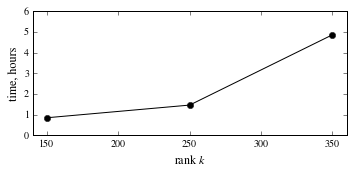

In [61]:
plt.figure(figsize=(5, 2.5))
ns = [150, 250, 350]
times = np.array([3036.0, 5247.0, 17515.0])

plt.plot(ns, times / (60 * 60), 'o-', color='black')
plt.xlim(140, 360)
plt.ylim(0, 6)
plt.xlabel('rank $k$')
plt.ylabel('time, hours')

plt.tight_layout()

plt.savefig('figures/nmf-runtime.pdf', format='pdf')
plt.show()